# LC3 DATA ANALYSIS

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy  as np

In [2]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict

In [3]:
# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

In [4]:
# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [6]:
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

# Get useful dataframe information
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

# COMPRESSION STRENGTH (CS)

### Visualize data

In [7]:
# Take kaolinite and compression strength
x = data['Kaolinite_content'].values # (Pandas dataframe).values = numpy array
y1  = data[ "1D"].values
y3  = data[ "3D"].values
y7  = data[ "7D"].values
y28 = data["28D"].values
y90 = data["90D"].values

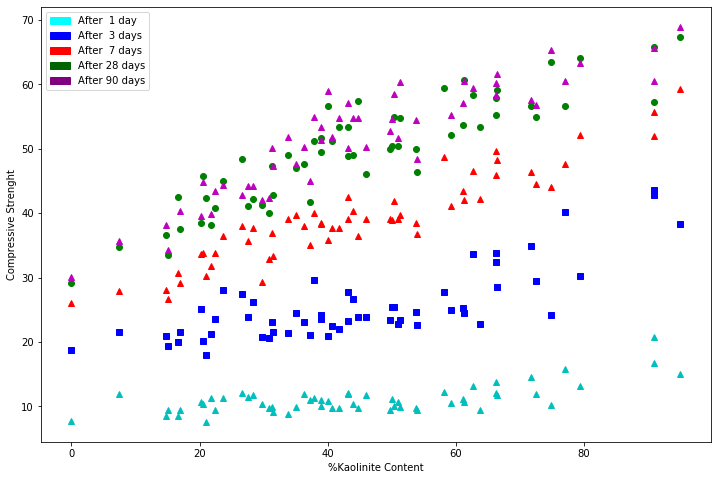

In [8]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous than the day 28 data.


**Second sight analysis:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to search also mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are more important for predicting the compression strength? That is what we are trying to answer in this part.

In [9]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [10]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Kaolinite_content,Dv50,D10,D90,Span (-),BET_specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Kaolinite_content,1.000000,-0.193500,-0.305015,-0.244189,0.084792,0.091568,-0.662171,0.916967,-0.253895,-0.201540,-0.334250,0.015434,-0.197303,-0.411571,0.415086,-0.036408,0.318173,0.023426,0.232083
Dv50,-0.193500,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
Span (-),0.084792,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_specific_surface,0.091568,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.662171,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916967,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.253895,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.201540,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [11]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.5

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

,1D,3D,7D,28D,90D
Kaolinite_content,0.672115,0.772572,0.931003,0.898135,0.910680
Dv50,-0.111246,-0.011320,-0.116061,-0.146193,-0.152193
D10,-0.274278,-0.351558,-0.296297,-0.287737,-0.290692
D90,-0.225330,-0.169381,-0.147715,-0.131897,-0.141472
Span (-),-0.008618,0.096408,0.176071,0.178734,0.099044
BET_specific_surface,-0.077832,-0.032558,0.083831,0.108786,0.198791
SiO2,-0.430950,-0.443933,-0.563664,-0.579837,-0.635442
Al2O3,0.614406,0.705345,0.834569,0.809226,0.845753
Fe2O3,-0.268702,-0.284461,-0.265054,-0.259344,-0.242389
CaO,-0.171936,-0.143753,-0.217687,-0.181013,-0.136114


In [12]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

,STD,STD.1,STD.2,STD.3,STD.4
Kaolinite_content,0.082912,0.444221,0.177116,0.328974,0.194653
Dv50,-0.118125,-0.129720,-0.113932,-0.185816,-0.105022
D10,-0.159055,-0.401368,-0.215840,-0.224444,-0.245231
D90,-0.018398,-0.070994,-0.032689,-0.082954,0.184129
Span (-),0.020704,0.055594,0.044010,0.022846,0.143911
BET_specific_surface,-0.345532,0.010624,-0.092784,0.131376,-0.059141
SiO2,0.006149,-0.302855,-0.086754,-0.322744,-0.080277
Al2O3,0.029920,0.394946,0.248389,0.322680,0.106657
Fe2O3,-0.137893,-0.100728,-0.108874,0.004947,0.019647
CaO,0.140246,0.012872,-0.146547,-0.101726,0.134408


In [13]:
# TODO: Review this! Delete if necessary!

# Relevant clay properties, first row show the number of non missing values
#data_restricted = data[['Kaolinite_content', 'Dv50', 'BET_specific_surface', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'K2O', 'TiO2']]
#data_restricted.describe()

**First sight analysis:**

* Several important correlations between features, be aware of this when chosing features for our model to avoid redundancy.
* Compression strength can be predicted quite good with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

### Feature selection

In [14]:
# TODO: Be sure of r² as the best way for determining which features to use for linear regression 
# TODO: Go to Andrés' notebook and take his function for getting the features with the biggest r²
# TODO: Read https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
#       Read https://machinelearningmastery.com/an-introduction-to-feature-selection/
#       Read A TRAP WHEN SELECTING FEATURES in https://machinelearningmastery.com/an-introduction-to-feature-selection/ 
#       Read https://en.wikipedia.org/wiki/Feature_selection
#       Read https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

In [44]:
def leave_one_out_validation(X, y, model=LinearRegression()):
    model.fit(X, y)  # train it
    
    #for f in range(len(feature_cols)):
    #    print("{0} * {1} + ".format(model.coef_[f], feature_cols[f]))
    print(str(model.intercept_) + ' + Kaolinite_content*' + str(model.coef_[1]))
    
    # get the list of predictions obtained while validating
    #predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    predicted = model.predict(X)
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
    ax.set_xlabel('Original')
    ax.set_ylabel('Predicted')
    plt.show()
    
    # Mean squared_error
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

In [16]:
# Add ones column to have w0 variable also in the linear regression
feature_cols = ['Kaolinite_content']
x = np.c_[np.ones(x.shape[0]), x]

35.26614365142824 + Kaolinite_content*0.3618699446602338


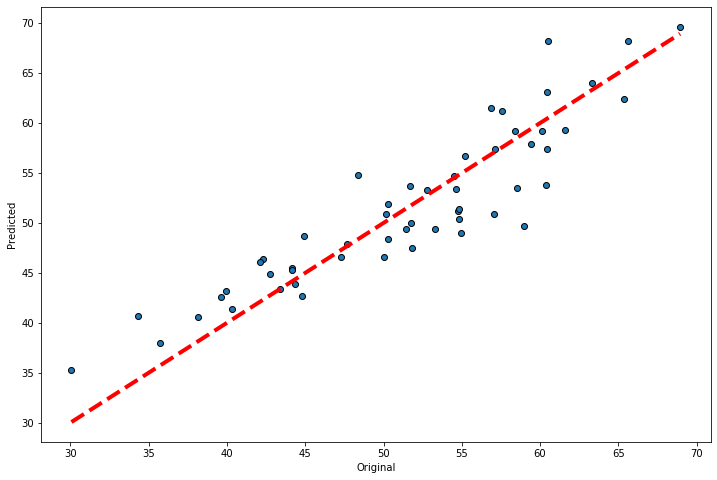

MSE: 12.488375248771913
R^2: 0.8293385347504323


In [45]:
leave_one_out_validation(x[:54], y90[:54])

In [21]:
# TODO: OLD CODE, REMOVE ONCE WE ARE SURE
#
# Leave one out cross validation for linear regression model considering only Kaolinite content
#def leave_one_out_validation(x, y, model=LinearRegression()):
#    l  = []
#    cv = LeaveOneOut()
#    for train_ix, test_ix in cv.split(x):
#        x_train, x_test = x[train_ix], x[test_ix]
#        y_train, y_test = y[train_ix], y[test_ix]
#
#        model.fit(x_train, y_train)
#    
#        y_pred = model.predict(x_test)
#    
#        l.append(mean_squared_error(y_test, y_pred))
#    
#    print("Model mean squared error: "+ str(sum(l)/len(l)))

In [22]:
# Add ones column to have w0 variable also in the linear regression
#x = np.c_[np.ones(x.shape[0]), x]

In [23]:
#leave_one_out_validation(x, y1)

In [24]:
#leave_one_out_validation(x, y3)

In [25]:
#leave_one_out_validation(x, y7)

In [26]:
#leave_one_out_validation(x, y28)

In [27]:
# We have to handle NaN
#leave_one_out_validation(x, y90)

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/
